# Weighted, directed, per cell graph

In [17]:
import imp
import csv
import torch
import random
import seaborn as sns
from collections import Counter
from scipy.special import softmax

from cell.Word2vec.wv import *
from cell.Word2vec.dataloader import *
from cell.Word2vec.prepare_vocab import *

from stellargraph import StellarDiGraph
from cell import utils, plot_utils, graph_utils, analysis

import cell.BiasedDirectedWeightedWalk as BDWW
imp.reload(utils)

<module 'cell.utils' from '/Users/fahimehb/Documents/git-workspace/celltypes/cell/utils.py'>

## Read the combined, normalized_by_max graph

In [2]:
path = "/Users/fahimehb/Documents/NPP_GNN_project/models/VISp/combined_layers/Interaction_mats_8.0/run1/"
combined_binarized_graph = pd.read_csv( path + "/sum_of_all_binarized_graphs.csv")
combined_binarized_graph = combined_binarized_graph.set_index("sample_id", drop=True)

In [3]:
print("Total number of cells")
v1_cells = combined_binarized_graph.index.tolist()
len(v1_cells)

Total number of cells


13426

In [4]:
combined_binarized_graph = combined_binarized_graph.drop(columns=["dendcluster_id", "Unnamed: 0"])
combined_binarized_graph.index.name = ""

In [235]:
cldf = pd.read_csv(path + "cldf_percell.csv", index_col="Unnamed: 0").drop(columns=["cluster_id"])
cldf = cldf.reset_index().rename(columns={"index":"cluster_id"})
cldf.cluster_id = cldf.cluster_id.astype(str)
cldf.head()

,cluster_id,sample_id,dendcluster_id,cluster_label,cluster_color,subclass_id,subclass_color,subclass_label,class_id,class_label,class_color
0,1,LS-14690_S02_E1-50,114,Pvalb Tpbg,#AF3F64,6,#D93137,Pvalb,1,GABAergic,#EF4136
1,2,LS-14690_S03_E1-50,7,L4 IT VISp Rspo1,#00979D,8,#00979D,L4,2,Glutamatergic,#27AAE1
2,3,LS-14690_S05_E1-50,7,L4 IT VISp Rspo1,#00979D,8,#00979D,L4,2,Glutamatergic,#27AAE1
3,4,LS-14690_S06_E1-50,7,L4 IT VISp Rspo1,#00979D,8,#00979D,L4,2,Glutamatergic,#27AAE1
4,5,LS-14690_S07_E1-50,7,L4 IT VISp Rspo1,#00979D,8,#00979D,L4,2,Glutamatergic,#27AAE1


## How many cell in each type?

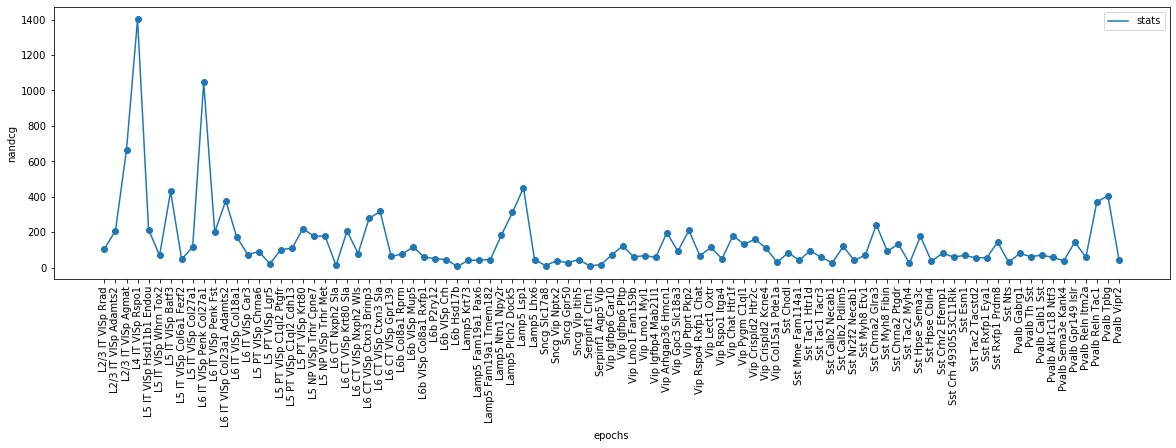

In [10]:
statistics = Counter(combined_binarized_graph['cluster_label'])
fig = plt.figure(figsize=(20,5))
plot_utils.plot_multiple_dict({"stats":statistics})

## Sampling 7 cells from each type to build a 651 by 651 graph

In [12]:
size = 7     # sample size
replace = False  # without replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
subsample_combined_binarized = combined_binarized_graph.groupby('cluster_label', as_index=False).apply(fn)

In [13]:
subsample = [j for (i,j) in subsample_combined_binarized.index.tolist()]

In [14]:
subsample_combined_binarized = combined_binarized_graph.loc[subsample][subsample]

In [251]:
subsample_combined_binarized.to_csv(path + "/subsample_combined_binarized.csv")

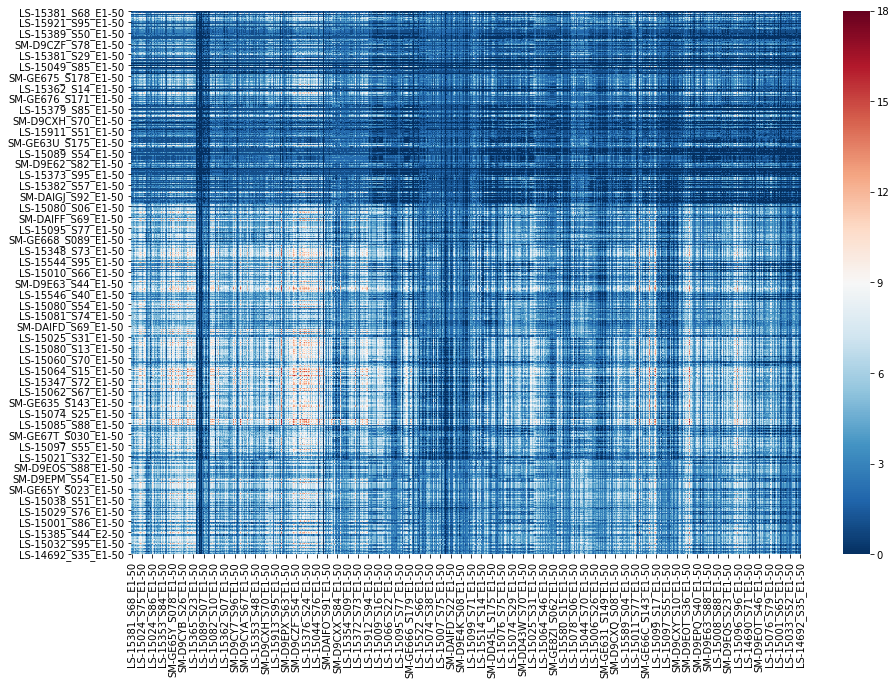

In [15]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(subsample_combined_binarized, cmap='RdBu_r')

### Histogram of all the values in the subsampled matrix

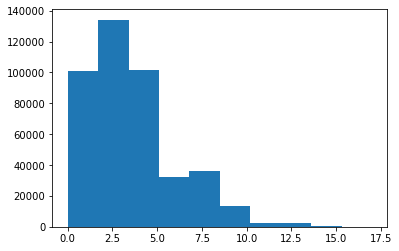

In [112]:
%matplotlib inline
plt.hist(subsample_combined_binarized.to_numpy().flatten())
plt.show()

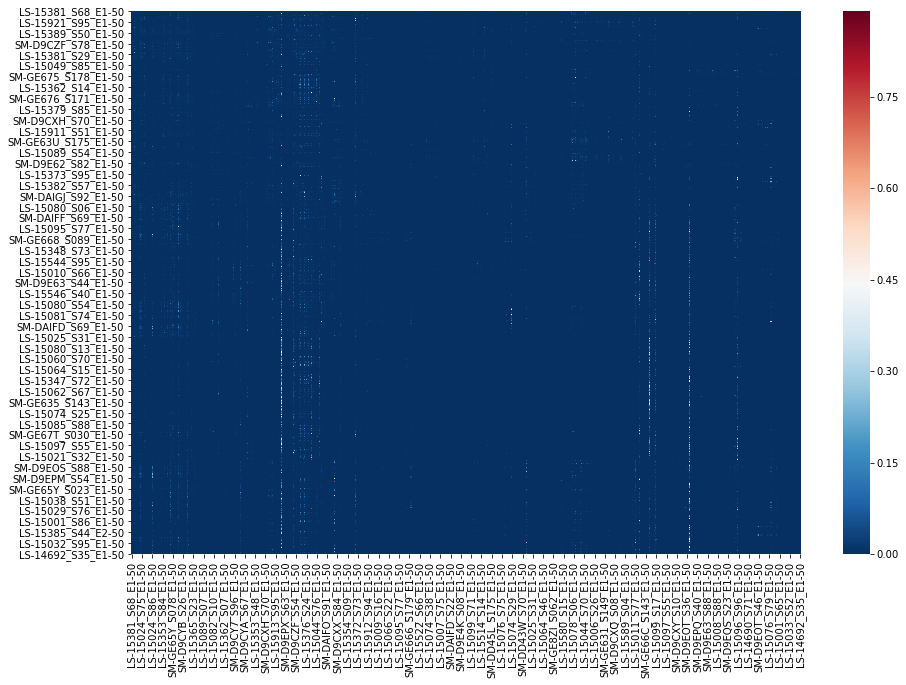

In [109]:
fig = plt.figure(figsize=(15,10))
soft_subsample_combined_binarized = softmax(subsample_combined_binarized/.6, axis=1)
sns.heatmap(soft_subsample_combined_binarized, cmap='RdBu_r')

In [252]:
soft_subsample_combined_binarized.to_csv(path + "/soft_subsample_combined_binarized.csv")

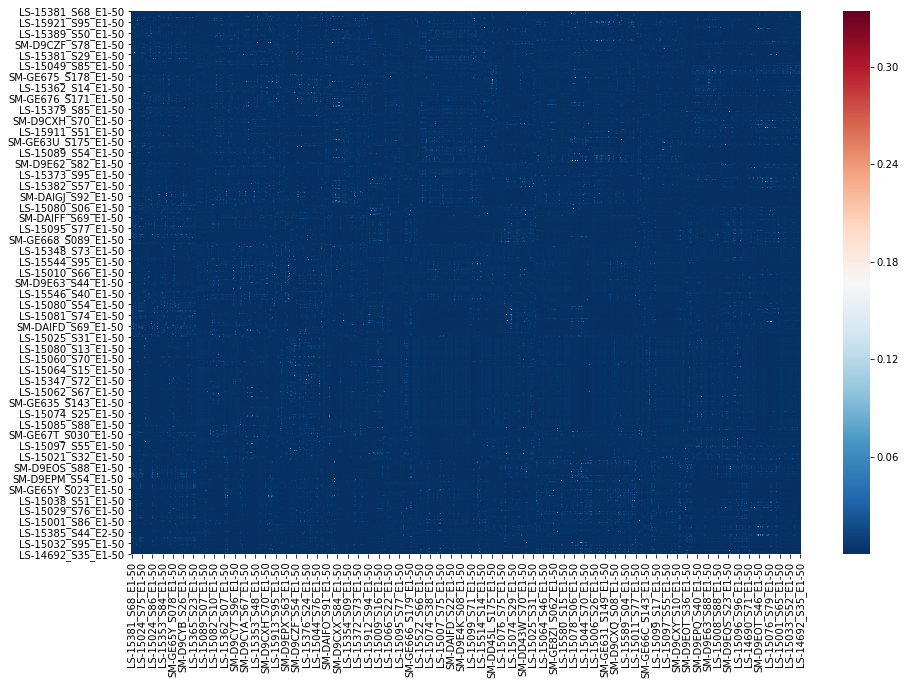

In [110]:
fig = plt.figure(figsize=(15,10))
double_stoch_soft_subsample_combined_binarized = graph_utils.apply_doubly_stochastic(soft_subsample_combined_binarized)
sns.heatmap(double_stoch_soft_subsample_combined_binarized, cmap='RdBu_r')

In [253]:
double_stoch_soft_subsample_combined_binarized.to_csv(path + "/double_stoch_soft_subsample_combined_binarized.csv")

Text(0.5, 0, 'Number of outgoing edge weights more than 0.01')

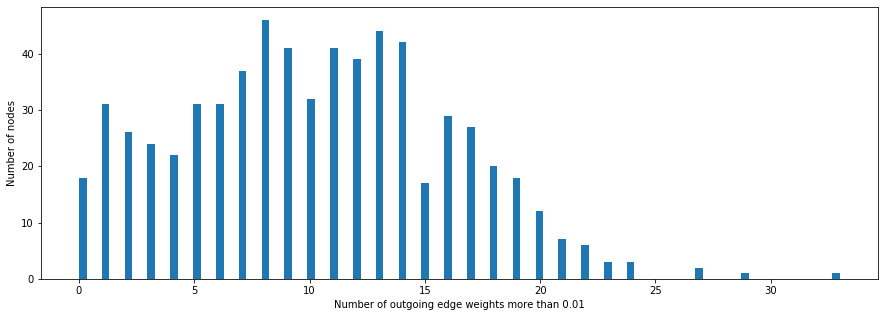

In [273]:
%matplotlib inline
fig = plt.figure(figsize=(15,5))
plt.hist(double_stoch_soft_subsample_combined_binarized[double_stoch_soft_subsample_combined_binarized>0.01].count(1), bins=100)
plt.ylabel("Number of nodes")
plt.xlabel("Number of outgoing edge weights more than 0.01")

Text(0.5, 0, 'Number of ingoing edge weights more than 0.01')

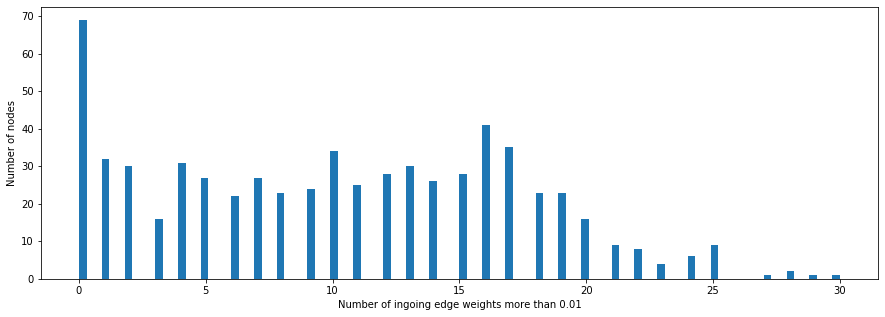

In [276]:
%matplotlib inline
fig = plt.figure(figsize=(15,5))
plt.hist(double_stoch_soft_subsample_combined_binarized[double_stoch_soft_subsample_combined_binarized>0.01].count(0), bins=100)
plt.ylabel("Number of nodes")
plt.xlabel("Number of ingoing edge weights more than 0.01")

In [275]:
double_stoch_soft_subsample_combined_binarized[double_stoch_soft_subsample_combined_binarized>0.01].count(1)

7125      0
12467     0
5659     14
2150     13
2909     13
         ..
1781     13
3146      9
1248     18
1214     11
108      12
Length: 651, dtype: int64

(array([639.,   8.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.72129818e-05, 7.93201020e-03, 1.58468074e-02, 2.37616046e-02,
        3.16764018e-02, 3.95911990e-02, 4.75059963e-02, 5.54207935e-02,
        6.33355907e-02, 7.12503879e-02, 7.91651851e-02]),
 <a list of 10 Patch objects>)

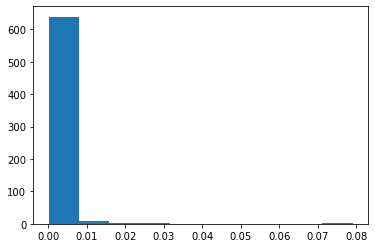

In [113]:
plt.hist([i for i in double_stoch_soft_subsample_combined_binarized.loc["LS-15063_S23_E1-50"].tolist()])

In [143]:
index_df = pd.DataFrame(double_stoch_soft_subsample_combined_binarized.index)
index_df.columns = ["sample_id"]
index_df.head()

,sample_id
0,LS-15381_S68_E1-50
1,SM-GE65I_S161_E1-50
2,LS-15349_S03_E1-50
3,LS-15041_S80_E1-50
4,LS-15060_S44_E1-50


In [147]:
sum(index_df.merge(cldf, on="sample_id")["sample_id"] == index_df["sample_id"])

651

In [150]:
cluster_id = index_df.merge(cldf, on="sample_id")["cluster_id"].tolist()

In [155]:
sample_ids = index_df["sample_id"].tolist()
double_stoch_soft_subsample_combined_binarized = double_stoch_soft_subsample_combined_binarized.loc[sample_ids][sample_ids]
double_stoch_soft_subsample_combined_binarized.index = cluster_id
double_stoch_soft_subsample_combined_binarized.columns = cluster_id

In [255]:
# edges = graph_utils.build_edge_list(weight_matrix=double_stoch_soft_subsample_combined_binarized, threshold=None, directed=True)
# nxg = graph_utils.build_nx_graph(source_target_weight=edges, directed=True)

# # 2) Create stellar Di graphs
# sdg = StellarDiGraph(nxg)
# BDWW.BeginWalk(sdg, begin_checks=True, weighted=True, directed=True)
# rw = BDWW.BiasedDirectedRandomWalk(sdg, directed=True, weighted=True, begin_checks=False)

# nodes = list(sdg.nodes())
# walks = rw.run(nodes=nodes, length=100, n=100, p=1, q=1, weighted=True, directed=True)

In [ ]:
utils.write_list_of_lists_to_csv("/Users/fahimehb/Documents/NPP_GNN_project/models/VISp/combined_layers/Interaction_mats_8.0/run1/walk_100_100_binary.csv", walks)

In [308]:
output_path = "/Users/fahimehb/Documents/NPP_GNN_project/models/VISp/combined_layers/Interaction_mats_8.0/run3/"
prefix = "/output"
finished_epoch = 2900 + 100
nandcg_E = []
nandcg_R = []
for e in range(0, finished_epoch, 100):
    print(e)
    epoch = e
    n_emb = 5

    E = pd.read_csv(output_path + prefix + "_" + str(epoch) + "_E_w1_" + str(n_emb) + "d.csv", index_col="Unnamed: 0")
    R = pd.read_csv(output_path + prefix + "_" + str(epoch) + "_R_w1_" + str(n_emb) + "d.csv", index_col="Unnamed: 0")

    E.index = E.index.astype(str)
    R.index = R.index.astype(str)
    

    E_to_R_dist = analysis.get_distance_between_eachrow_of_one_df_with_all_rows_of_other_df(E[["Z" + str(i) for i in range(n_emb)]], 
                                                                                        R[["Z" + str(i) for i in range(n_emb)]])
    
    nandcg_E.append(analysis.Compute_node_average_ndcg(adj=double_stoch_soft_subsample_combined_binarized, e_to_r=E_to_R_dist, k=15))   
    nandcg_R.append(analysis.Compute_node_average_ndcg(adj=double_stoch_soft_subsample_combined_binarized.T, e_to_r=E_to_R_dist.T, k=15)) 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


KeyboardInterrupt: 

In [290]:
%matplotlib qt5
plt.scatter([i for i in range(0, finished_epoch, 100)],nandcg_E, color='blue')
plt.plot([i for i in range(0, finished_epoch, 100)], nandcg_E, color='blue', label='nandcg_E')
plt.scatter([i for i in range(0, finished_epoch, 100)],nandcg_R, color='red')
plt.plot([i for i in range(0, finished_epoch, 100)], nandcg_R, color='red', label='nandcg_R')
plt.xlabel("epochs")
plt.ylabel("nandcg@15")
plt.legend()

In [262]:
%matplotlib qt5
ndcg_E, _ = plot_utils.plot_node_average_ndcg(adj=double_stoch_soft_subsample_combined_binarized, e_to_r=E_to_R_dist, k=15, figsize=(25,5))

In [209]:
node_id = "9792"
print(E_to_R_dist.columns[np.argsort(E_to_R_dist[node_id])][0:10])
print(double_stoch_soft_subsample_combined_binarized.columns[np.argsort(-1 * double_stoch_soft_subsample_combined_binarized.loc[node_id])][0:10])

Index(['7205', '8767', '10496', '9204', '12403', '5977', '12807', '2418',
       '6404', '8382'],
      dtype='object')
Index(['11454', '11435', '7328', '11498', '8835', '12325', '2779', '7338',
       '12943', '11839'],
      dtype='object')


In [210]:
np.sort(double_stoch_soft_subsample_combined_binarized.loc[node_id])[-10:]

array([0.01724384, 0.02002538, 0.02069699, 0.02191653, 0.02195511,
       0.02456332, 0.02635928, 0.02654369, 0.02788877, 0.07988301])

In [211]:
double_stoch_soft_subsample_combined_binarized.loc[node_id]["8781"]

0.010681446833994877

In [212]:
[i for i in E_to_R_dist.columns[np.argsort(E_to_R_dist[node_id])][0:50] 
 if i in double_stoch_soft_subsample_combined_binarized.columns[np.argsort(-1 * double_stoch_soft_subsample_combined_binarized.loc[node_id])][0:50]]

['6404', '8935', '8781']

In [217]:
from sklearn.metrics import ndcg_score

nodes = nodes = [j for j in E_to_R_dist.index.tolist()]
true_y = np.array([double_stoch_soft_subsample_combined_binarized.loc[node_id].tolist()])
node_imp_dict = analysis.get_distance_node_importance(node_id, E_to_R_dist)
predicted_y = np.array([[node_imp_dict[i] for i in double_stoch_soft_subsample_combined_binarized.columns]])
ndcg_score(true_y, predicted_y, k=15)

0.7746504441705365

In [291]:
emit, rece = analysis.summarize_embedding_results(E, R, "cluster_label", cldf)

In [292]:
%matplotlib qt5
plot_utils.plot_ER(emitter=emit,
                  receiver=rece,
                  figsize=(15,15),
                  plot_dim=3,
                  annotation=False,
                  resolution="cluster_label",
                  side_by_side=True,
                  )

In [303]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rece["Z0"], rece["Z1"], rece["Z2"], c=rece["cluster_color"], label="R", marker ="x")
ax.legend()

In [304]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(emit["Z0"], emit["Z1"], emit["Z2"], c=emit["cluster_color"], label="E", marker ="o")
ax.legend()

In [305]:
emb_umap = analysis.Compute_umap(pd.concat((emit, rece)), 5)

In [307]:
em = emb_umap[emb_umap['node_act']=="E"]
em = em.set_index('cluster_id')

re = emb_umap[emb_umap['node_act']=="R"]
re = re.set_index('cluster_id')

fig = plt.figure(figsize=(8,8))

# em = emit
# re = rece
fig = plot_utils.plot_ER(emitter=em, 
                   receiver=re, 
                   figsize=(12,8), 
                   plot_dim=2, 
                   annotation=False, 
                   annotation_label="cluster_label",
                   E_marker='o', 
                   R_marker='x', 
                   resolution="cluster_label",
                   side_by_side=True, 
                   scatter_point_size=100,
                  )
